In [1]:
# Módulos de Astropy
from astropy.io import fits
from astropy.table import Table

# Módulos de visualización y cálculo numérico
import matplotlib.pyplot as plt
import numpy as np

# Módulos de sklearn para división de datos y búsqueda en grilla
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

# Módulos de TensorFlow y TensorFlow Addons
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Activation, LeakyReLU
import tensorflow_addons as tfa
from tensorflow.keras.callbacks import ModelCheckpoint, LambdaCallback

# Módulo de itertools para la generación de productos cartesianos
from itertools import product

import os
import sys

2023-04-30 20:31:40.818354: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-30 20:31:40.931474: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-30 20:31:41.426468: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-30 20:31:41.426518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot

In [2]:
# Cargar los datos a partir de los archivos FITS
path_datos = "../data_actualizada/"
path = path_datos + "ZW3.msw_image.fits"
hdul = fits.open(path)

In [3]:
ruta_carpeta_resultados = "/home/21953404Victor/SDC3/SDC3GIT/catalogos/catalogo completo 1/labels"
archivos = os.listdir(ruta_carpeta_resultados)

def clamp(value, min_value, max_value):
    return max(min(value, max_value), min_value)

def procesar_archivo(path_txt):
    with open(path_txt, "r") as f:
        lines = f.readlines()

    label = np.zeros((2048, 2048), dtype=int)

    for line in lines:
        x, y, _ = line.split()
        x, y = int(float(x)), int(float(y))

        for i in range(-4, 4):
            for j in range(-4, 4):
                x_coord = clamp(x + i, 0, 2047)
                y_coord = clamp(y + j, 0, 2047)
                label[y_coord, x_coord] = 1

    return label

# Crear una lista para guardar los datos procesados
output_data=[]

# Procesar todos los archivos de texto en la carpeta de resultados
for archivo in archivos:
    path_txt = os.path.join(ruta_carpeta_resultados, archivo)
    label = procesar_archivo(path_txt)
    output_data.append(label)

In [4]:
def plot_history(history, title="", show=True):
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Gráfico de precisión
    axes[0].plot(history.history["accuracy"], label="Entrenamiento")
    axes[0].plot(history.history["val_accuracy"], label="Validación")
    axes[0].set_xlabel("Épocas")
    axes[0].set_ylabel("Precisión")
    axes[0].set_title("Precisión - " + title)
    axes[0].legend()

    # Gráfico de pérdida
    axes[1].plot(history.history["loss"], label="Entrenamiento")
    axes[1].plot(history.history["val_loss"], label="Validación")
    axes[1].set_xlabel("Épocas")
    axes[1].set_ylabel("Pérdida")
    axes[1].set_title("Pérdida - " + title)
    axes[1].legend()

    if show:
        plt.show()

# Modelo 1

In [4]:
num_samples = 400
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=42)

# Eliminar data y output_data para liberar memoria
del data
del output_data


In [9]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                      

Epoch 1/5


2023-04-27 15:24:32.432360: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 5368709120 exceeds 10% of free system memory.
2023-04-27 15:24:34.023385: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 10737418240 exceeds 10% of free system memory.
2023-04-27 15:24:39.520519: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.
2023-04-27 15:24:39.525447: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.


  1/160 [..............................] - ETA: 20:17 - loss: 0.6931 - accuracy: 0.2586

2023-04-27 15:24:45.452402: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 4831838208 exceeds 10% of free system memory.


160/160 [==============================] - 970s 6s/step - loss: 0.1512 - accuracy: 0.9703 - val_loss: 0.0672 - val_accuracy: 0.9800
Epoch 2/5
160/160 [==============================] - 966s 6s/step - loss: 0.0627 - accuracy: 0.9815 - val_loss: 0.0567 - val_accuracy: 0.9832
Epoch 3/5
160/160 [==============================] - 973s 6s/step - loss: 0.0607 - accuracy: 0.9824 - val_loss: 0.0538 - val_accuracy: 0.9837
Epoch 4/5
160/160 [==============================] - 983s 6s/step - loss: 0.0593 - accuracy: 0.9828 - val_loss: 0.0541 - val_accuracy: 0.9828
Epoch 5/5
160/160 [==============================] - 999s 6s/step - loss: 0.0562 - accuracy: 0.9831 - val_loss: 0.0566 - val_accuracy: 0.9836


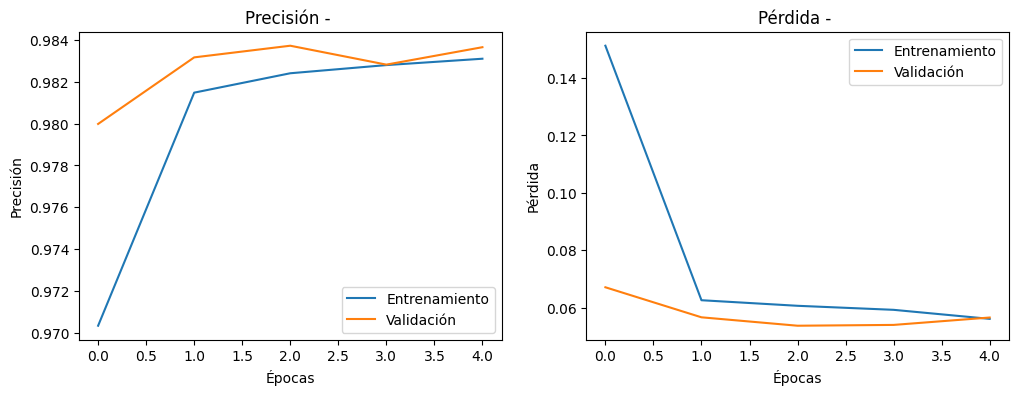

In [11]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=5, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-1.h5")
plot_history(history)

# MODELO 2

In [5]:
num_samples = 500
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=42)

# Eliminar data y output_data para liberar memoria
del data
del output_data

In [6]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
# Inicializar Adam con una tasa de aprendizaje de 0.0001
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-04-28 15:04:14.454825: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-28 15:04:14.459021: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-28 15:04:14.459034: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-28 15:04:14.459637: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/8


2023-04-28 15:04:17.021355: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13421772800 exceeds 10% of free system memory.


200/200 [==============================] - 1232s 6s/step - loss: 0.3699 - accuracy: 0.9678 - val_loss: 0.1088 - val_accuracy: 0.9741
Epoch 2/8
200/200 [==============================] - 1230s 6s/step - loss: 0.0998 - accuracy: 0.9756 - val_loss: 0.0930 - val_accuracy: 0.9762
Epoch 3/8
200/200 [==============================] - 1235s 6s/step - loss: 0.0822 - accuracy: 0.9777 - val_loss: 0.0765 - val_accuracy: 0.9784
Epoch 4/8
200/200 [==============================] - 1237s 6s/step - loss: 0.0691 - accuracy: 0.9798 - val_loss: 0.0662 - val_accuracy: 0.9803
Epoch 5/8
200/200 [==============================] - 1240s 6s/step - loss: 0.0622 - accuracy: 0.9813 - val_loss: 0.0673 - val_accuracy: 0.9806
Epoch 6/8
200/200 [==============================] - 1242s 6s/step - loss: 0.0596 - accuracy: 0.9819 - val_loss: 0.0620 - val_accuracy: 0.9811
Epoch 7/8
200/200 [==============================] - 1244s 6s/step - loss: 0.0575 - accuracy: 0.9824 - val_loss: 0.0585 - val_accuracy: 0.9819
Epoch 8/8

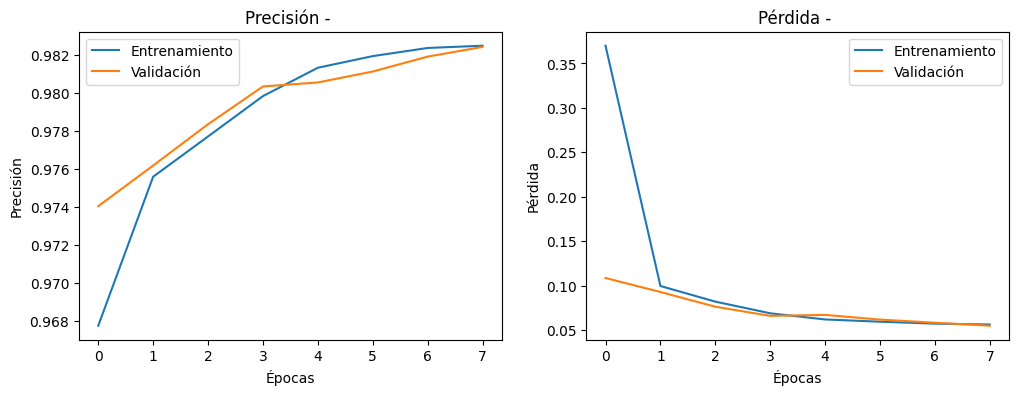

In [7]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=8, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-2.h5")
plot_history(history)

## Modelo 3

In [5]:
num_samples = 500
indices = np.random.choice(hdul[0].data.shape[0], num_samples, replace=False)
output_data = np.array(output_data)[indices]

# Guardar los índices en un archivo de texto
def save_indices_to_txt(indices, filename="indices.txt"):
    np.savetxt(filename, indices, fmt='%d')
save_indices_to_txt(indices, "indices_cnn_completa.txt")

# Cargar los datos utilizando una vista de las filas seleccionadas
data = hdul[0].data[indices, :, :, np.newaxis].astype("float32") / 255.0

# Dividir los datos en conjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(data, output_data, test_size=0.2, random_state=42)

# Eliminar data y output_data para liberar memoria
del data
del output_data

In [6]:
# Construir la CNN
model = Sequential()
model.add(Conv2D(32, (3, 3), activation="relu", padding="same", input_shape=(x_train.shape[1], x_train.shape[2], 1)))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(tfa.layers.InstanceNormalization())
model.add(MaxPooling2D((2, 2), padding="same"))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(1, (3, 3), activation="sigmoid", padding="same"))

# Compilar el modelo
# Inicializar Adam con una tasa de aprendizaje de 0.0001
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss="binary_crossentropy", metrics=["accuracy"])
model.summary()

2023-04-30 20:33:04.773301: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-30 20:33:04.777415: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/hadoop/lib/native:
2023-04-30 20:33:04.777428: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2023-04-30 20:33:04.778071: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 2048, 2048, 32)    320       
                                                                 
 instance_normalization (Ins  (None, 2048, 2048, 32)   64        
 tanceNormalization)                                             
                                                                 
 max_pooling2d (MaxPooling2D  (None, 1024, 1024, 32)   0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 1024, 1024, 32)    9248      
                                                                 
 instance_normalization_1 (I  (None, 1024, 1024, 32)   64        
 nstanceNormalization)                                           
                                                        

/home/21953404Victor/SDC3/tutorial-env/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [7]:
# Entrenar el modelo
history = model.fit(x_train, y_train, epochs=100, batch_size=2, validation_data=(x_val, y_val))
model.save("cnn-cpu-completa-3.h5")
plot_history(history)

2023-04-30 20:33:05.163600: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 6710886400 exceeds 10% of free system memory.


Epoch 1/100


2023-04-30 20:33:07.103133: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 13421772800 exceeds 10% of free system memory.


200/200 [==============================] - 1205s 6s/step - loss: 0.1454 - accuracy: 0.9706 - val_loss: 0.0657 - val_accuracy: 0.9810
Epoch 2/100
200/200 [==============================] - 1202s 6s/step - loss: 0.0617 - accuracy: 0.9821 - val_loss: 0.0559 - val_accuracy: 0.9825
Epoch 3/100
200/200 [==============================] - 1216s 6s/step - loss: 0.0603 - accuracy: 0.9827 - val_loss: 0.0574 - val_accuracy: 0.9831
Epoch 4/100
200/200 [==============================] - 1223s 6s/step - loss: 0.0569 - accuracy: 0.9831 - val_loss: 0.0536 - val_accuracy: 0.9833
Epoch 5/100
200/200 [==============================] - 1230s 6s/step - loss: 0.0548 - accuracy: 0.9834 - val_loss: 0.0535 - val_accuracy: 0.9832
Epoch 6/100
200/200 [==============================] - 1231s 6s/step - loss: 0.0530 - accuracy: 0.9837 - val_loss: 0.0505 - val_accuracy: 0.9839
Epoch 7/100
200/200 [==============================] - 1232s 6s/step - loss: 0.0550 - accuracy: 0.9838 - val_loss: 0.0529 - val_accuracy: 0.98